<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">ASSO: Amended Salp Swarm Optimizer</h1> 
    <h2 style="color:#483D8B;text-align:center;">Analysis of the results on CEC 2017 functions</h2>
    <br>31 July 2021 @ UniBG
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Senior Postdoc – University of Bergamo<br>
    Department of Human and Social Sciences<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Piazzale S. Agostino 2,<br>
        24129, Bergamo, Italy<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:andrea.tangherloni@unibg.it">andrea.tangherloni@unibg.it</a> <br>
        <span style="color:#483D8B;"><b>Website:</b></span>
            <a href="https://www.andreatangherloni.com">www.andreatangherloni.com</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from statannot import add_stat_annotation

from matplotlib import cm

In [3]:
from itertools import combinations

def multipleComparisons(dataframe,
                        group_by     = None,
                        data         = None,
                        test         = "Mann–Whitney U test",
                        correction   = "bonferroni",
                        alpha        = 0.05, 
                        verbose      = True,
                        min_elements = 20,
                        **kwargs):
    
    tests       = ["Mann–Whitney U test", "Wilcoxon paired test", "Wilcoxon test", "t-test paired",
                   "t-test independent", "Welch's t-test", "Kruskal-Wallis test",
                   "Anderson-Darling test", "Kolmogorov-Smirnov test"]
    corrections = [None, 'bonferroni', 'sidak', 'holm-sidak', 'holm', 'simes-hochberg', 'hommel',
                   'fdr_bh', 'fdr_by', 'fdr_tsbh', 'fdr_tsbky']
    toExit      = False
    
    if group_by is None:
        print("'group_by' can not be equal to None. Please provide one of the columns")
        toExit = True
    elif group_by not in dataframe.columns:
        print("'group_by'=''%s' is not one of the columns. Please provide one among:"%group_by, "|".join(dataframe.columns))
        toExit = True
    
    if data is None:
        print("'data' can not be equal to None. Please provide one of the columns")
        toExit = True
    
    elif data not in dataframe.columns:
        print("'data'='%s' is not one of the columns. Please provide one among:"%data, "|".join(dataframe.columns))
        toExit = True
        
    if test not in tests:
        print("'test'='%s' is not one of the possible tests. Please provide one among:"%test, "|".join(tests))
        toExit = True
        
    if correction not in corrections:
        print("'correction'='%s' is not one of the possible corrections. Please provide one among:"%correction, "|".join(corrections))
        print("'bonferroni'     : one-step correction")
        print("'sidak'          : one-step correction")
        print("'holm-sidak'     : step down method using Sidak adjustments")
        print("'holm'           : step-down method using Bonferroni adjustments")
        print("'simes-hochberg' : step-up method (independent)")
        print("'hommel'         : closed method based on Simes tests (non-negative)")
        print("'fdr_bh'         : Benjamini/Hochberg (non-negative)")
        print("'fdr_by'         : Benjamini/Yekutieli (negative)")
        print("'fdr_tsbh'       : two stage fdr correction (non-negative)")
        print("'fdr_tsbky'      : two stage fdr correction (non-negative)")
        
        toExit = True
        
    if alpha < 0 and alpha > 1:
        print("'alpha'='%d' is not valid. Please provide a value in the range [0,1]"%alpha)
        toExit = True
    
    if toExit:
        return None
    
    dataframe[group_by] = dataframe[group_by].astype('category')
    
    combs = list(combinations(dataframe[group_by].cat.categories, 2))
    
    results = pd.DataFrame(columns = ["Group 1","Group 2", "p-value", "corrected p-value"],
                           index   = list(range(len(combs))))
    
    # ******************************************* Mann–Whitney U test *******************************************
    if test=="Mann–Whitney U test":
        print("* Running 'Mann–Whitney U test' ('scipy.stats.mannwhitneyu')")
        from scipy.stats import mannwhitneyu

        use_continuity = True
        alternative    = None
        
        if "use_continuity" in kwargs.keys() and kwargs["use_continuity"] in [True, False]:
            use_continuity = kwargs["use_continuity"]
        if "alternative" in kwargs.keys() and kwargs["alternative"] in [None, 'two-sided', 'less', 'greater']:
            alternative = kwargs["alternative"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:
                try:
                    _, pval = mannwhitneyu(g0,
                                           g1,
                                           use_continuity = use_continuity,
                                           alternative    = alternative)
                except:
                    pval = 1.0
                    
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval

    
    # ******************************************* Wilcoxon paired test *******************************************
    elif test=="Wilcoxon paired test":
        
        if verbose:
            print("* Running 'Wilcoxon paired test' ('scipy.stats.wilcoxon')")
            
        from scipy.stats import wilcoxon

        zero_method = 'wilcox'
        correction  = False
        alternative = 'two-sided'
        mode        = 'auto'
        
        if "zero_method" in kwargs.keys() and kwargs["zero_method"] in ['pratt', 'wilcox', 'zsplit']:
            zero_method = kwargs["zero_method"]
        if "correction" in kwargs.keys() and kwargs["correction"] in [True, False]:
            correction = kwargs["correction"]
        if "alternative" in kwargs.keys() and kwargs["alternative"] in ['two-sided', 'less', 'greater']:
            alternative = kwargs["alternative"]
        if "mode" in kwargs.keys() and kwargs["mode"] in ['auto', 'exact', 'approx']:
            mode = kwargs["mode"]
       
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
            
            if len(g0) != len(g1):
                print("The samples '%s' and '%s' must have the same length"%(comb[0],comb[1]))
                return None
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = wilcoxon(dataframe[dataframe[group_by]==comb[0]][data],
                                   dataframe[dataframe[group_by]==comb[1]][data],
                                   zero_method = zero_method,
                                   correction  = correction,
                                   alternative = alternative,
                                   mode        = mode)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
    
    
    # ******************************************* Wilcoxon test *******************************************
    elif test=="Wilcoxon test":    
        if verbose:
            print("* Running 'Wilcoxon test' ('scipy.stats.ranksums')")
            
        from scipy.stats import ranksums
              
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = ranksums(g0,g1)

            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
    
    
    # ******************************************* Wilcoxon paired test *******************************************
    elif test=="t-test paired":
        if verbose:
            print("* Running 't-test paired' ('scipy.stats.ttest_rel')")
            
        from scipy.stats import ttest_rel

        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if len(g0) != len(g1):
                print("The samples '%s' and '%s' must have the same length"%(comb[0],comb[1]))
                return None
            
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = ttest_rel(g0,
                                    g1,
                                    nan_policy = nan_policy)
                                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            
            
    # ******************************************* t-test independent *******************************************
    elif test=="t-test independent":
        if verbose:
            print("* Running 't-test independent' ('scipy.stats.ttest_ind')")
            
        from scipy.stats import ttest_ind
        
        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
            
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:  
                _, pval = ttest_ind(g0,
                                    g1,
                                    equal_var  = True,
                                    nan_policy = nan_policy)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
    
    
    # ******************************************* Welch's t-test *******************************************
    elif test=="Welch's t-test":
        
        if verbose:
            print("* Running 'Welch's t-test' ('scipy.stats.ttest_ind with equal_var=False')")
            
        from scipy.stats import ttest_ind
        
        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:
                _, pval = ttest_ind(g0,
                                    g1,
                                    equal_var  = False,
                                    nan_policy = nan_policy)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            
    # ******************************************* Kruskal-Wallis test *******************************************
    elif test=="Kruskal-Wallis test":
        
        if verbose:
            print("* Running 'Kruskal-Wallis test' ('scipy.stats.kruskal')")
            
        from scipy.stats import kruskal
        
        nan_policy = 'propagate'
        
        if "nan_policy" in kwargs.keys() and kwargs["nan_policy"] in ['propagate', 'raise', 'omit']:
            nan_policy = kwargs["nan_policy"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, pval = kruskal(g0,
                                  g1,
                                  nan_policy = nan_policy)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval

            
    # ******************************************* Anderson-Darling test *******************************************
    elif test=="Anderson-Darling test":
        
        if verbose:
            print("* Running 'Anderson-Darling test' ('scipy.stats.anderson_ksamp')")
            
        from scipy.stats import anderson_ksamp
        
        midrank = True
        
        if "midrank" in kwargs.keys() and kwargs["midrank"] in [True, False]:
            midrank = kwargs["midrank"]
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:     
                _, _, pval = anderson_ksamp([g0,
                                             g1],
                                            midrank = midrank)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            
    
    # ******************************************* Kolmogorov-Smirnov test *******************************************
    elif test=="Kolmogorov-Smirnov test":
        
        if verbose:
            print("* Running 'Kolmogorov-Smirnov test' ('scipy.stats.ks_2samp')")
            
        from scipy.stats import ks_2samp
        
        alternative = 'two-sided'
        mode        = 'auto'
        
        if "alternative" in kwargs.keys() and kwargs["alternative"] in ['two-sided', 'less', 'greater']:
            alternative = kwargs["alternative"]
        if "mode" in kwargs.keys() and kwargs["mode"] in ['auto', 'exact', 'asymp']:
            mode = kwargs["mode"]
       
                
        for idx,comb in enumerate(combs):
            
            g0 = dataframe[dataframe[group_by]==comb[0]][data]
            g1 = dataframe[dataframe[group_by]==comb[1]][data]
                        
            if (len(g0) < min_elements) or (len(g1) < min_elements):
                pval = np.NaN
            else:         
                _, pval = ks_2samp(g0,
                                   g1,
                                   alternative = alternative,
                                   mode        = mode)
                        
            results["Group 1"][idx] = comb[0]
            results["Group 2"][idx] = comb[1]
            results["p-value"][idx] = pval
            

#     pvals_corrected = [np.NaN]*len(combs)
    if correction is not None:
        from statsmodels.stats.multitest import multipletests
        
        _, pvals_corrected, _, _ = multipletests(results["p-value"].tolist(),
                                       alpha  = alpha,
                                       method = correction)
        
#         for idx,pval in enumerate(pvals):
            
#             if np.isnan(results["p-value"][idx]):
                
        
        results["corrected p-value"] = pvals_corrected
    
    return results

In [4]:
import matplotlib


def heatmap(data, row_labels, col_labels, ax=None, colorbar=True, 
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
        ax = plt.gca()
        
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if colorbar:
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.04, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    else:
        cbar = None
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(row_labels)
    ax.set_yticklabels(col_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-90)

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.grid(which="major", color="w", linestyle='-', linewidth=0)
    ax.tick_params(which="minor", bottom=False, left=False, top=False)
    ax.tick_params(which="major", bottom=False, left=False, top=False)
    
    ax.patch.set(hatch='xx', edgecolor='black')
    

    return im, cbar

# CEC 2017

In [5]:
repetitions = 30
dimensions  = 10

comparisons_CEC = {}
ABFs = {}
STDs = {}

for f in range(1, 31):
    
    path_random = "ResultsCEC2017/RandomSearch/"+"f%d_%d/"%(f,dimensions)
    path_sso    = "ResultsCEC2017/SSO/"+"f%d_%d/"%(f,dimensions)
    path_asso   = "ResultsCEC2017/ASSO/"+"f%d_%d/"%(f,dimensions)
    path_cmaes  = "ResultsCEC2017/CMAES/"+"f%d_%d/"%(f,dimensions)
    path_de     = "ResultsCEC2017/DE/"+"f%d_%d/"%(f,dimensions)
    
    comparisons_CEC["f%d"%f] = {}
    comparisons_CEC["f%d"%f]["Random"]   = []
    comparisons_CEC["f%d"%f]["SSO"]      = []
    comparisons_CEC["f%d"%f]["SSO-code"] = []
    comparisons_CEC["f%d"%f]["ASSO"]     = []
    comparisons_CEC["f%d"%f]["CMAES"]    = []
    comparisons_CEC["f%d"%f]["DE"]       = []
    
    ABFs["f%d"%f] = {}
    ABFs["f%d"%f]["Random"]   = np.zeros(2000)
    ABFs["f%d"%f]["SSO"]      = np.zeros(2000)
    ABFs["f%d"%f]["SSO-code"] = np.zeros(2000)
    ABFs["f%d"%f]["ASSO"]     = np.zeros(2000)
    ABFs["f%d"%f]["CMAES"]    = np.zeros(2000)
    ABFs["f%d"%f]["DE"]       = np.zeros(2000)
    
    for r in range(repetitions):
        ABFs["f%d"%f]["Random"]   += np.loadtxt(path_random+"random_rep%d_fitness"%r)
        ABFs["f%d"%f]["SSO"]      += np.loadtxt(path_sso   +"sso_rep%d_fitness"%r)
        ABFs["f%d"%f]["SSO-code"] += np.loadtxt(path_sso   +"sso_code_rep%d_fitness"%r)
        ABFs["f%d"%f]["ASSO"]     += np.loadtxt(path_asso  +"asso_rep%d_fitness"%r)
        ABFs["f%d"%f]["CMAES"]    += np.loadtxt(path_cmaes +"cmaes_rep%d_fitness"%r)
        ABFs["f%d"%f]["DE"]       += np.loadtxt(path_de    +"de_rep%d_fitness"%r)

        comparisons_CEC["f%d"%f]["Random"].append((np.loadtxt(path_random+"random_rep%d_fitness"%r))[-1])
        comparisons_CEC["f%d"%f]["SSO"].append((np.loadtxt(path_sso      +"sso_rep%d_fitness"%r)[-1]))
        comparisons_CEC["f%d"%f]["SSO-code"].append((np.loadtxt(path_sso +"sso_code_rep%d_fitness"%r))[-1])
        comparisons_CEC["f%d"%f]["ASSO"].append((np.loadtxt(path_asso    +"asso_rep%d_fitness"%r))[-1])
        comparisons_CEC["f%d"%f]["CMAES"].append((np.loadtxt(path_cmaes  +"cmaes_rep%d_fitness"%r))[-1])
        comparisons_CEC["f%d"%f]["DE"].append((np.loadtxt(path_de        +"de_rep%d_fitness"%r))[-1])

    ABFs["f%d"%f]["Random"]   /= repetitions
    ABFs["f%d"%f]["SSO"]      /= repetitions
    ABFs["f%d"%f]["SSO-code"] /= repetitions
    ABFs["f%d"%f]["ASSO"]     /= repetitions
    ABFs["f%d"%f]["CMAES"]    /= repetitions
    ABFs["f%d"%f]["DE"]       /= repetitions

    
    STDs["f%d"%f] = {}
    STDs["f%d"%f]["Random"]   = np.zeros(2000)
    STDs["f%d"%f]["SSO"]      = np.zeros(2000)
    STDs["f%d"%f]["SSO-code"] = np.zeros(2000)
    STDs["f%d"%f]["ASSO"]     = np.zeros(2000)
    STDs["f%d"%f]["CMAES"]    = np.zeros(2000)
    STDs["f%d"%f]["DE"]       = np.zeros(2000)
    
    for r in range(repetitions):
        STDs["f%d"%f]["Random"]   += (np.loadtxt(path_random+"random_rep%d_fitness"%r)   - ABFs["f%d"%f]["Random"])**2
        STDs["f%d"%f]["SSO"]      += (np.loadtxt(path_sso   +"sso_rep%d_fitness"%r)      - ABFs["f%d"%f]["SSO"])**2
        STDs["f%d"%f]["SSO-code"] += (np.loadtxt(path_sso   +"sso_code_rep%d_fitness"%r) - ABFs["f%d"%f]["SSO-code"])**2
        STDs["f%d"%f]["ASSO"]     += (np.loadtxt(path_asso  +"asso_rep%d_fitness"%r)     - ABFs["f%d"%f]["ASSO"])**2
        STDs["f%d"%f]["CMAES"]    += (np.loadtxt(path_cmaes +"cmaes_rep%d_fitness"%r)    - ABFs["f%d"%f]["CMAES"])**2
        STDs["f%d"%f]["DE"]       += (np.loadtxt(path_de    +"de_rep%d_fitness"%r)       - ABFs["f%d"%f]["DE"])**2
    
    STDs["f%d"%f]["Random"]   /= repetitions
    STDs["f%d"%f]["SSO"]      /= repetitions
    STDs["f%d"%f]["SSO-code"] /= repetitions
    STDs["f%d"%f]["ASSO"]     /= repetitions
    STDs["f%d"%f]["CMAES"]    /= repetitions
    STDs["f%d"%f]["DE"]       /= repetitions
    
    STDs["f%d"%f]["Random"]   = np.sqrt(STDs["f%d"%f]["Random"])
    STDs["f%d"%f]["SSO"]      = np.sqrt(STDs["f%d"%f]["SSO"])
    STDs["f%d"%f]["SSO-code"] = np.sqrt(STDs["f%d"%f]["SSO-code"])
    STDs["f%d"%f]["ASSO"]     = np.sqrt(STDs["f%d"%f]["ASSO"])
    STDs["f%d"%f]["CMAES"]    = np.sqrt(STDs["f%d"%f]["CMAES"])
    STDs["f%d"%f]["DE"]       = np.sqrt(STDs["f%d"%f]["DE"])

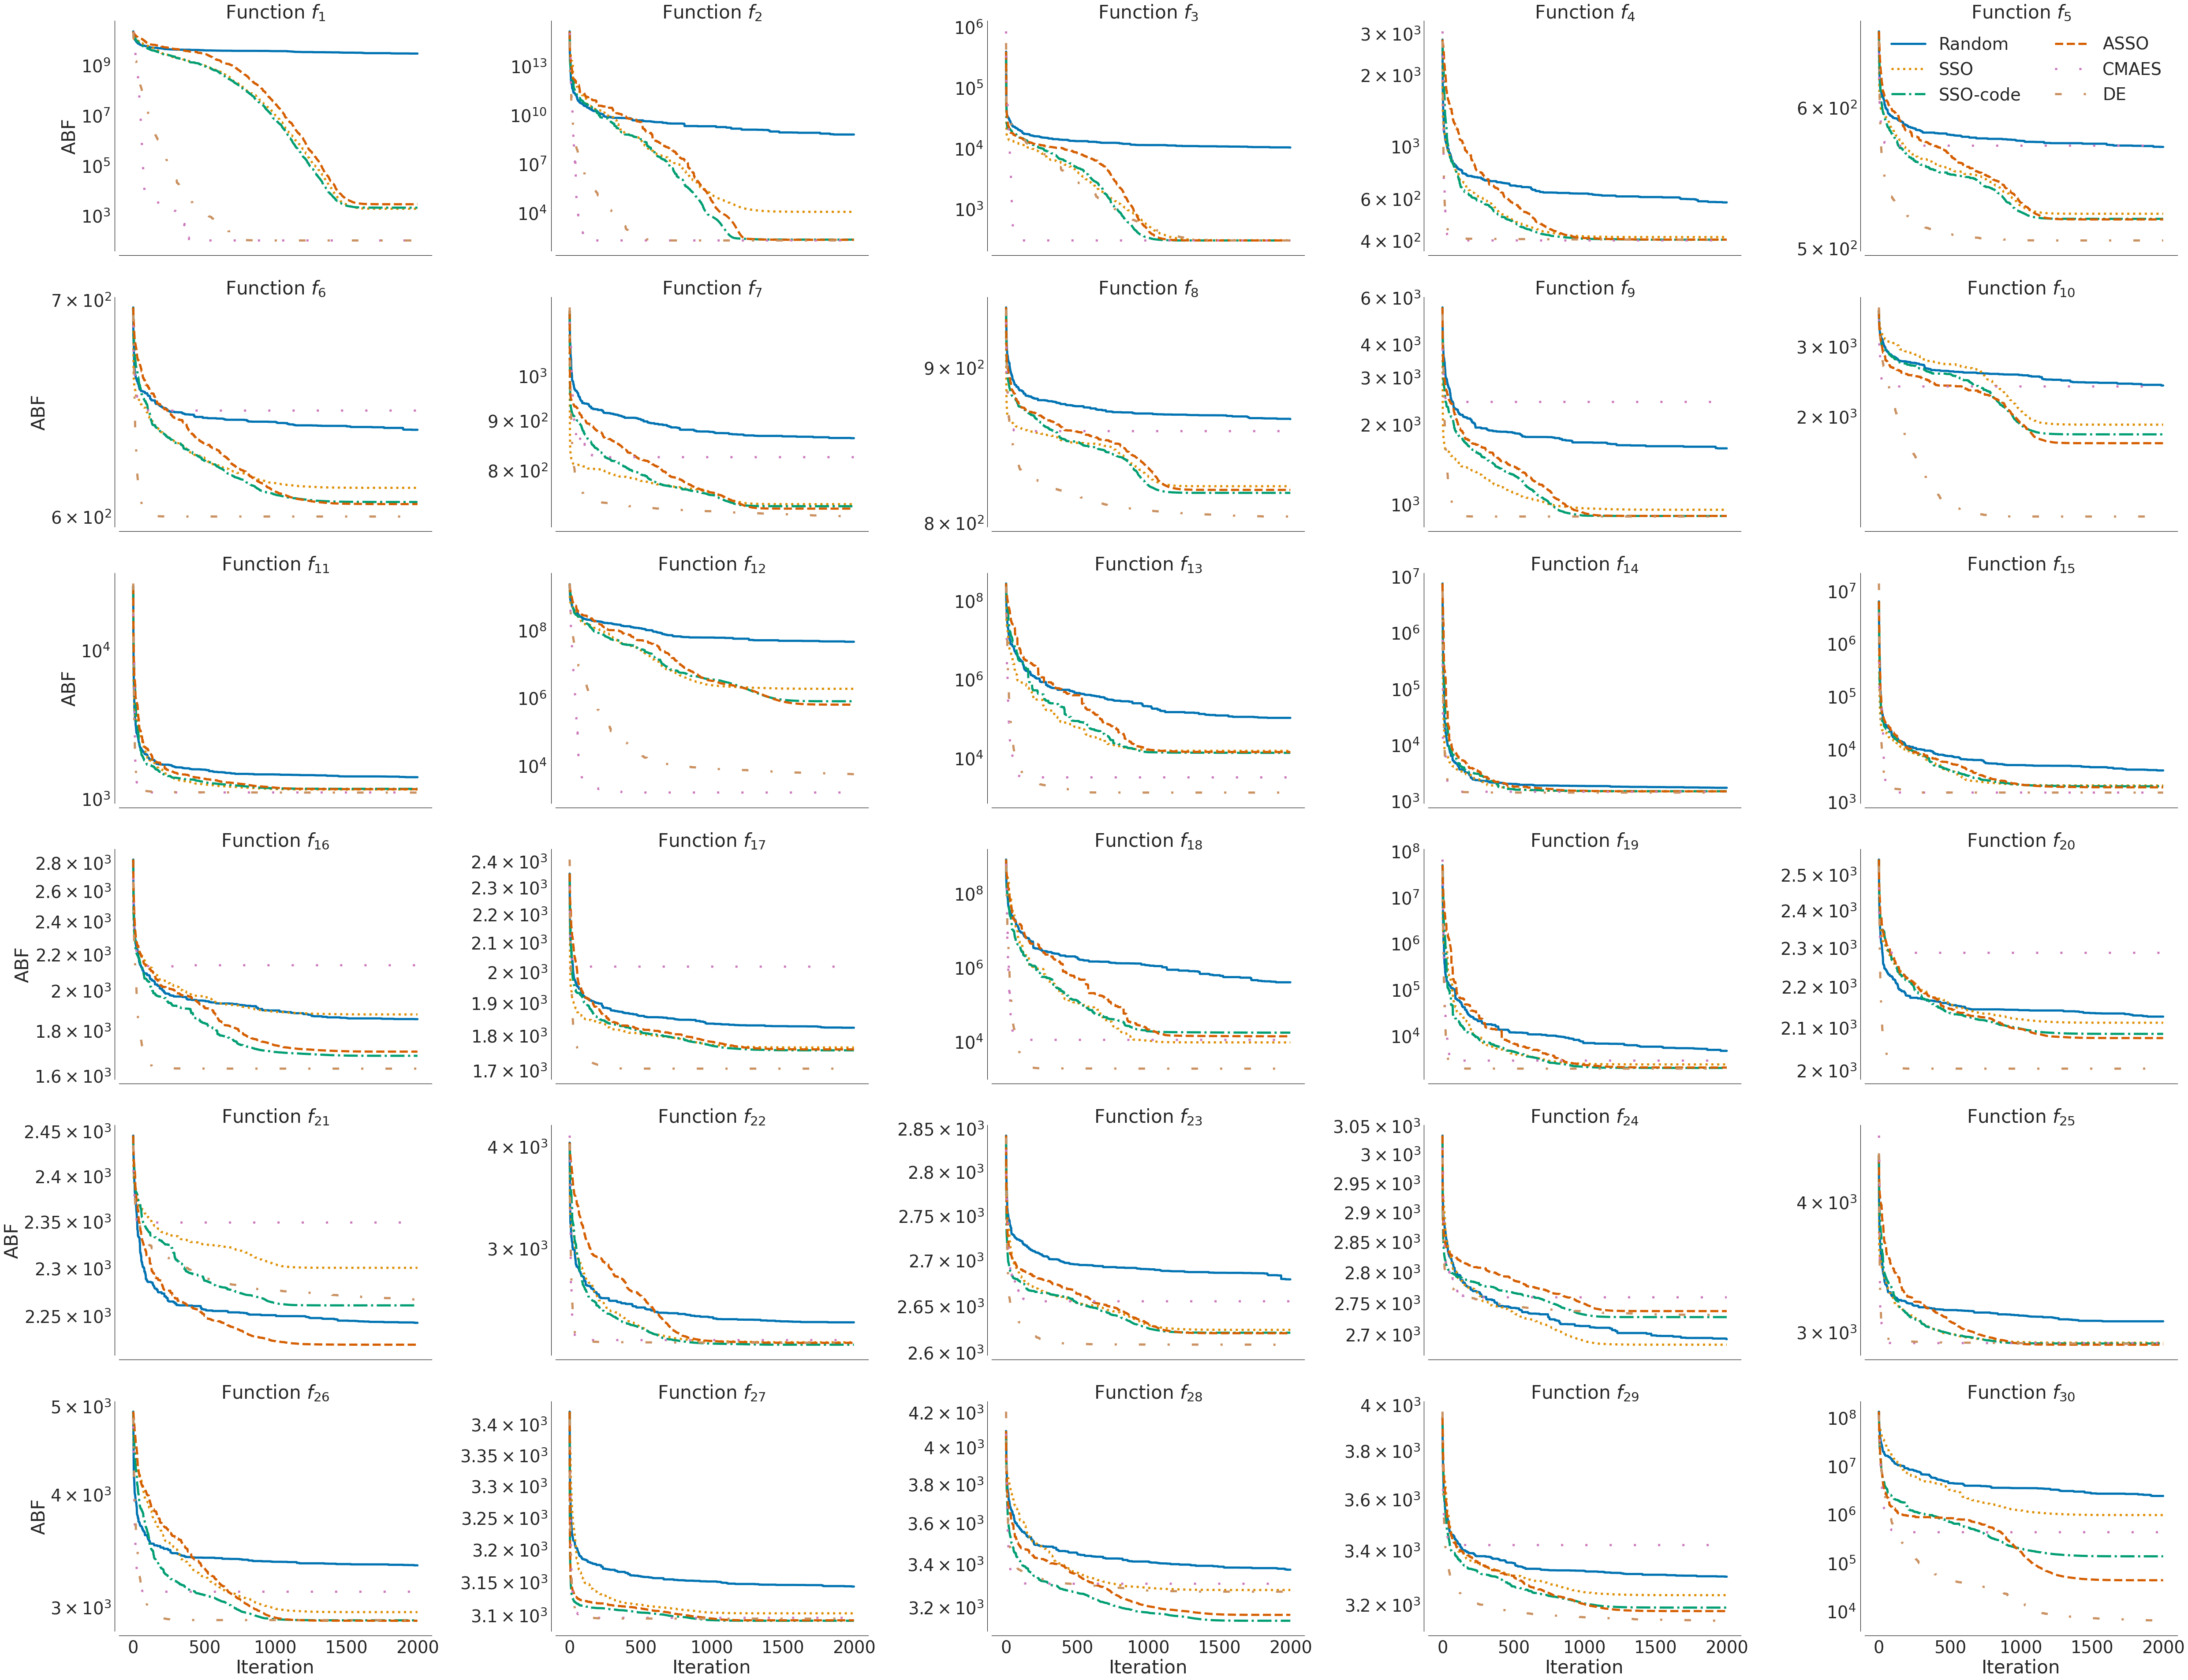

In [88]:
linestyles = {}
linestyles['solid']                 = "solid"

linestyles['dotted']                = "dotted"
linestyles['loosely dotted']        = (0, (1, 10))
linestyles['densely dotted']        = (0, (1, 1))

linestyles['dashed']                = "dashed"
linestyles['loosely dashed']        = (0, (5, 10))
linestyles['densely dashed']        = (0, (5, 1))

linestyles['dashdotted']            = "dashdot"
linestyles['loosely dashdotted']    = (0, (3, 10, 1, 10))
linestyles['densely dashdotted']    = (0, (3, 1, 1, 1))

#linestyles['dashdotdotted']         = "dashdotdotted"
linestyles['loosely dashdotdotted'] = (0, (3, 10, 1, 10, 1, 10))
linestyles['densely dashdotdotted'] = (0, (3, 1, 1, 1, 1, 1))


iterations = list(range(2000))
palette    = sns.color_palette("colorblind")

n_rows = 6
n_cols = 5

f, axs = plt.subplots(n_rows,n_cols,figsize=(14*n_cols,9*n_rows))
sns.set(font_scale=3.5)
sns.set_style("white")

for f in range(1, 31):
    idx = f-1
    
    if f == 5:
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["Random"],   label="Random",   linewidth=5, color=palette[0], linestyle=linestyles['solid'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["SSO"],      label="SSO",      linewidth=5, color=palette[1], linestyle=linestyles['dotted'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["SSO-code"], label="SSO-code", linewidth=5, color=palette[2], linestyle=linestyles['dashdotted'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["ASSO"],     label="ASSO",     linewidth=5, color=palette[3], linestyle=linestyles['dashed'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["CMAES"],    label="CMAES",    linewidth=5, color=palette[4], linestyle=linestyles["loosely dotted"])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["DE"],       label="DE",       linewidth=5, color=palette[5], linestyle=linestyles["loosely dashdotted"])
        axs[idx//n_cols, idx%n_cols].legend(frameon=False, ncol=2)
        
    else:
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["Random"],   linewidth=5, color=palette[0], linestyle=linestyles['solid'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["SSO"],      linewidth=5, color=palette[1], linestyle=linestyles['dotted'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["SSO-code"], linewidth=5, color=palette[2], linestyle=linestyles['dashdotted'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["ASSO"],     linewidth=5, color=palette[3], linestyle=linestyles['dashed'])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["CMAES"],    linewidth=5, color=palette[4], linestyle=linestyles["loosely dotted"])
        axs[idx//n_cols, idx%n_cols].plot(iterations, ABFs["f%d"%f]["DE"],       linewidth=5, color=palette[5], linestyle=linestyles["loosely dashdotted"])


    axs[idx//n_cols, idx%n_cols].set_yscale('log')
     
    if idx//n_cols==5:
        axs[idx//n_cols, idx%n_cols].set_xlabel('Iteration')
    else:
        axs[idx//n_cols, idx%n_cols].set_xticks([])
    
    if idx%n_cols==0:
        axs[idx//n_cols, idx%n_cols].set_ylabel('ABF')
    
    axs[idx//n_cols, idx%n_cols].set_title('Function $f_{%d}$'%(idx+1))

sns.despine(offset=10, trim=False)

plt.tight_layout()
#plt.savefig("ABFs_cec2017_10dims.pdf")

# Comparisons

In [ ]:
dataframes  = {}
comparisons = {}
for f in range(1, 31):
    data = comparisons_CEC["f%d"%f]["Random"] + comparisons_CEC["f%d"%f]["SSO"] + comparisons_CEC["f%d"%f]["SSO-code"] + comparisons_CEC["f%d"%f]["ASSO"] + comparisons_CEC["f%d"%f]["CMAES"] + comparisons_CEC["f%d"%f]["DE"]
    
    dataframes["f%d"%f]           = pd.DataFrame(data = data, columns=["Fitness"])
    dataframes["f%d"%f]["Method"] = ["Random"]*30 + ["SSO"]*30 + ["SSO-code"]*30 + ["ASSO"]*30 + ["CMAES"]*30 + ["DE"]*30
    dataframes["f%d"%f]['Method'] = pd.Categorical(dataframes["f%d"%f]['Method'],
                                                   categories=["Random", "SSO", "SSO-code", "ASSO", "CMAES", "DE"],
                                                   ordered=False)
    
    kwargs = {}
    kwargs["alternative"] = 'two-sided'
    comparisons["f%d"%f]  = multipleComparisons(dataframes["f%d"%f],
                                                group_by     = "Method",
                                                data         = "Fitness",
                                                min_elements = 15,
                                                **kwargs)

In [ ]:
algorithms = comparisons["f1"]["Group 1"].tolist() + comparisons["f1"]["Group 2"].tolist()
indexes    = np.unique(algorithms, return_index=True)[1]
algorithms = [algorithms[index] for index in sorted(indexes)]
functions  = ["f%d"%f for f in range(1, 31)]

n_rows = 6
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,4*n_rows))

for idx,function in enumerate(functions):
    data = comparisons[function]
    
    p_values = pd.DataFrame(index=algorithms, columns=algorithms).astype(float)
        
    for a1 in algorithms:
        for a2 in algorithms:
            
            p_val = data[(data["Group 1"] == a1) & (data["Group 2"] == a2)]["corrected p-value"].tolist()
            if len(p_val) == 1:
                p_values[a1][a2] = p_val[0]

    qrates = np.array([0.0, 0.01, 0.05, 0.1, 1.0])
    norm = matplotlib.colors.BoundaryNorm(np.array([0.0, 0.01, 0.05, 0.1, 1.0]), 4)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[0::][norm(x)])
    
    sns.set(font_scale=1.5)
    
    
    ax = axes[idx//n_cols, idx%n_cols]
    
    colorbar = False
    cbarlabel = ""
    
    if idx%n_cols==4:
        colorbar = True
        cbarlabel = "Confidence interval"
        
    
    x_labels = ["" for a in algorithms]
    y_labels = ["" for a in algorithms]
    
    if idx%n_cols==0:
        y_labels = algorithms
    
    if idx//n_cols==5:
        x_labels = algorithms
    
    im, _ = heatmap(p_values.values,
                    x_labels,
                    y_labels,
                    colorbar=colorbar,
                    ax=ax,
                    cmap=plt.get_cmap("RdBu", 4),
                    norm=norm,
                    cbar_kw=dict(ticks=[0.0, 0.01, 0.05, 0.1, 1.0], format=fmt),
                    cbarlabel=cbarlabel)
    
    ax.set_title("Function $f_{%d}$"%(idx+1))
    
plt.tight_layout()
#plt.savefig("Heatmaps_cec2017_10dims.pdf")

In [ ]:
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

## set y ticks    
order = max([ABFs["f%d"%f]["Random"][0],
             ABFs["f%d"%f]["SSO"][0],
             ABFs["f%d"%f]["SSO-code"][0],
             ABFs["f%d"%f]["ASSO"][0],
             ABFs["f%d"%f]["CMAES"][0],
             ABFs["f%d"%f]["DE"][0]])

minimum = min([ABFs["f%d"%f]["Random"][-1],
               ABFs["f%d"%f]["SSO"][-1],
               ABFs["f%d"%f]["SSO-code"][-1],
               ABFs["f%d"%f]["ASSO"][-1],
               ABFs["f%d"%f]["CMAES"][-1],
               ABFs["f%d"%f]["DE"][-1]])

order   = int(round(np.log10(order)))
minimum = int(round(np.log10(minimum)))    

axs[idx//n_cols, idx%n_cols].yaxis.set_major_formatter(OOMFormatter(order, "%1.1f"))  
axs[idx//n_cols, idx%n_cols].yaxis.set_minor_formatter(OOMFormatter(order, "%1.1f"))

major_locator = matplotlib.ticker.LogLocator(numticks=5)
axs[idx//n_cols, idx%n_cols].yaxis.set_major_locator(major_locator)

#minor_locator = matplotlib.ticker.LogLocator(numticks=3)

#axs[idx//n_cols, idx%n_cols].yaxis.set_minor_locator(minor_locator)